# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto

Import packages

In [4]:
# Install scikit-learn if not already installed
%pip install scikit-learn

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
import os
from kaggle.api.kaggle_api_extended import KaggleApi

Note: you may need to restart the kernel to use updated packages.


Download data using Kaggle KPI

In [17]:
# Specify the dataset and the path to save it
dataset_name = 'tunguz/used-car-auction-prices'  # Replace with your actual Kaggle dataset name
download_path = './kaggle_datasets'     # Folder to store the dataset

# Create download path if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Check if file exists
dataset_file_path = os.path.join(download_path, 'car_prices.csv')   
# Check if the dataset already exists in the folder
if not os.path.exists(dataset_file_path):
    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()  # Authenticate using your Kaggle credentials

    # Download the dataset
    print(f"Downloading {dataset_name}...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

    print("Download complete.")
else:
    print("Dataset already exists, download skipped.")

# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')
df.head()

Dataset already exists, download skipped.


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


# Data Cleaning
__Done__
1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)


__#TODO__
2) convert (or maybe drop) ['saledate']
3) One-Hot encode ['body'] (collapse all 85 body types)


In [21]:
print("Start: ", df.shape)
# 1 - Remove rows with missing values
df = df.dropna()
# 2 - One-hot encode the 'transmission' column
print(df['transmission'].unique())
df['auto_trans'] = (df['transmission'] == 'automatic').astype(int)
# 3 - One-hot encode the 'body' column
print(len(df['body'].unique()))


# Drop old columns
#df.drop('transmission', axis=1, inplace=True)
print("Finish: ", df.shape)


Start:  (472336, 17)
['automatic' 'manual']
85
Finish:  (472336, 17)


# Data Viz
Plot 'mmr' v. 'sellingprice'

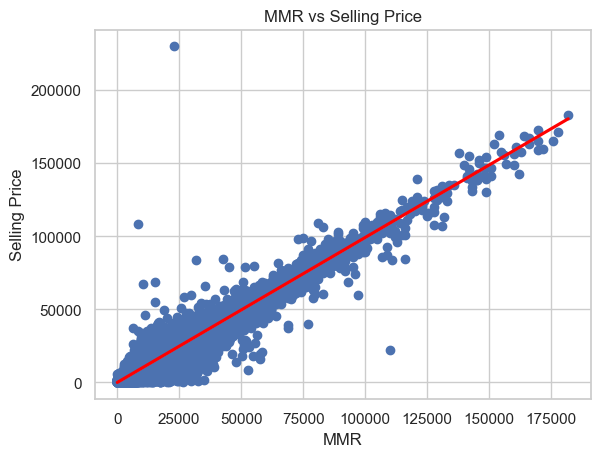

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of seaborn
sns.set(style="whitegrid")
plt.scatter(df['mmr'], df['sellingprice']) # Create a scatter plot
sns.regplot(x='mmr', y='sellingprice', data=df, scatter=False, color='red') # Linear fit line
plt.title('MMR vs Selling Price')
plt.xlabel('MMR')
plt.ylabel('Selling Price')
plt.show()

# Scatter plot is showing so outlires, lets take a closer looke at the data to find and remove them
Identify outliers

In [ ]:
outliers_rows = df.index[
    ((df['mmr'] > 100000) | (df['sellingprice'] > 100000)) &
    ((df['mmr'] > df['sellingprice'] * 2) | (df['mmr'] < df['sellingprice'] * 0.5))
].tolist()

print("Outliers: ", outliers_rows)
df.loc[outliers_rows]

Outliers:  [160201, 344905, 405316]


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
160201,2010,Ford,Escape,XLT,SUV,automatic,1fmcu0d77aka54695,oh,3.7,82985.0,red,gray,pat obrien chevrolet south,8250,108200,Tue Jan 20 2015 01:30:00 GMT-0800 (PST)
344905,2014,Ford,Escape,Titanium,SUV,automatic,1fmcu9j98eua23833,mo,4.3,27802.0,green,tan,ford-lincoln dealer program,22800,230000,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
405316,2013,Mercedes-Benz,G-Class,G63 AMG,SUV,automatic,wdcyc7df0dx200577,pa,4.8,23947.0,black,black,adcock brothers inc,110000,22250,Fri Mar 20 2015 02:00:00 GMT-0700 (PDT)
